# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error as mse

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

from IPython.display import display, HTML, Image
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', -1)

PATH = '/datasets/'
SEED = 21

In [2]:
!pip install seaborn==0.11.0
import seaborn as sns
sns.set_style('darkgrid')

Defaulting to user installation because normal site-packages is not writeable


In [3]:
data = pd.read_csv(os.path.join(PATH, 'autos.csv'),
                   parse_dates=['DateCrawled', 'LastSeen', 'DateCreated'])
data.info()
data.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null datetime64[ns]
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null datetime64[ns]
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 43.3+ MB


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
330755,2016-03-30 17:57:47,2900,wagon,2001,manual,143,3er,150000,7,petrol,bmw,NaN,2016-03-30,0,49152,2016-04-03 09:15:26
353341,2016-03-08 16:38:55,169,sedan,1998,manual,74,vectra,150000,8,petrol,opel,no,2016-03-08,0,4319,2016-03-14 06:18:07
161985,2016-04-06 21:25:34,1200,small,1998,manual,0,corsa,150000,2,NaN,opel,no,2016-04-06,0,56564,2016-04-06 21:25:34


In [4]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Удалим колонки которые явно не имеют смысла для предсказания цены:
  
- DateCrawled - дата получения объявления из базы
- DateCreated - дата создания объявления
- LastSeen - последняя активность пользователя
- NumberOfPictures - количество фото, оно везде равно 0
  
Дополнительно выделим категориальные колонки

In [5]:
col_to_drop = ['DateCrawled', 'LastSeen', 'DateCreated', 'NumberOfPictures']
data = data.drop(columns=col_to_drop)

cat_col = ['VehicleType', 'Gearbox', 'Model', 'FuelType',
           'Brand', 'RegistrationMonth', 'NotRepaired']

Посмотрим пропуски в оставшихся колонках

In [6]:
def show_na(df):
    data_info = (df.isna() | df.isnull()).sum()
    res = (pd.concat([data_info / df.shape[0], data_info], axis=1,  keys=['percent', 'abs'])
           .sort_values('percent', ascending=False))
    return res

show_na(data)

,percent,abs
NotRepaired,0.200791,71154
VehicleType,0.105794,37490
FuelType,0.092827,32895
Gearbox,0.055967,19833
Model,0.055606,19705
Price,0.000000,0
RegistrationYear,0.000000,0
Power,0.000000,0
Kilometer,0.000000,0
RegistrationMonth,0.000000,0


Заполним пропуски в категориальных фичах текстом 'Nan'

In [7]:
data[cat_col] = data[cat_col].fillna('Nan')

Для признаков Price, Power и RegistrationYear построим графики распределение.

In [8]:
def viz_distribution(col, col_name):
    
    '''
    Функция как аргумент принимает признак и его название. 
    Функция возвращает информацию о распределении признака.  
    '''
    sns.displot(x = col, legend=True, kde=True, height=5.7, aspect=1.5, bins=100)
    plt.title('Распределение значений признака ' + str(col_name).title(), fontsize=16)

    plt.figure(figsize=(9.7, 6))
    sns.boxplot(y=col)

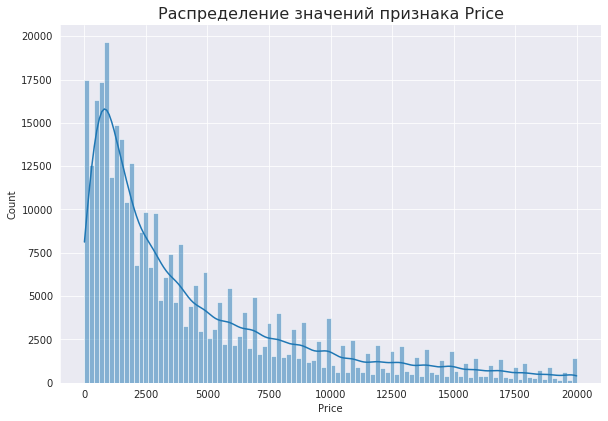

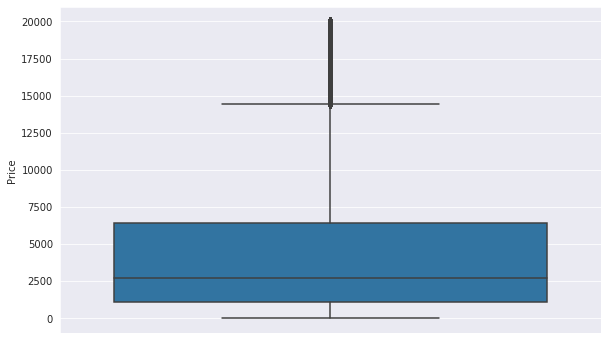

In [9]:
viz_distribution(data['Price'], 'Price')

Аномальными можно считать объекты с ценой меньше 200 денежных единиц и выше ~15к денежных единиц. Как видим, таких данных почти 10%, что достаточно много.

In [10]:
print('Доля аномалий:', len(data.query('Price < 200 or Price >14600')) / len(data) *100)

Доля аномалий: 9.908880291447614


Удалим аномальные объекты из датафрейма и сохраним результат в переменной clean_data.

In [11]:
clean_data = data.query('Price >= 200 or Price <=15000')

Исследуем признак Power.

(-10, 1000)

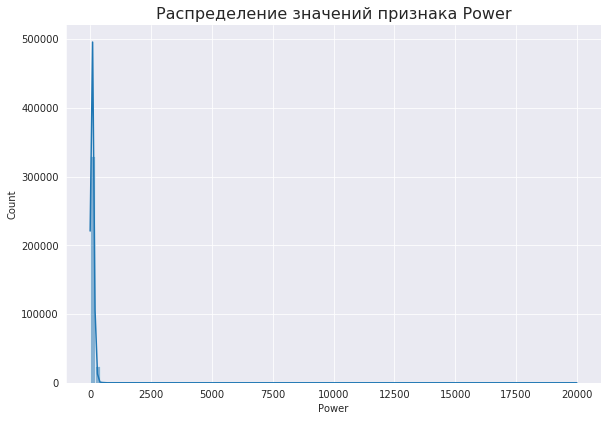

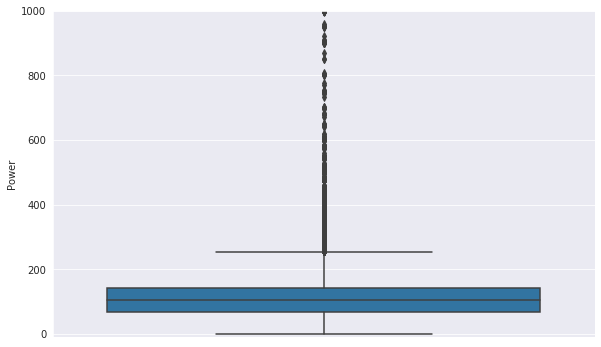

In [12]:
viz_distribution(data['Power'], 'Power')
plt.ylim(-10, 1000)

Видим, что аномальными можно считать объекты с мощностью больше 218 л.с. Также важно отметить, что этот признак содержит большое количество объектов со значением 0. Скорее всего, владелец автомобиля, при заполнинии анкеты, посто не указал мощность своего автомобиля, поэтому эти 0 можно воспринимать как пропуски и заменить на медиану, в зависимости от таких признаков как Brand, Model и FuelType.

In [13]:
clean_data['Power'] = clean_data['Power'].replace(0, np.nan)
median = clean_data.groupby(['Brand', 'Model', 'FuelType'])['Power'].transform('median')
clean_data['Power'] = clean_data['Power'].fillna(median)

Проверим к-во объектов без информации о мощности автомобиля.

In [14]:
print('К-во пропусков:', clean_data['Power'].isnull().sum())

К-во пропусков: 100


Удалим эти строки.

In [15]:
clean_data.dropna(inplace=True)
clean_data.isnull().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
PostalCode           0
dtype: int64

Исследуем более подробно признак RegistrationYear.

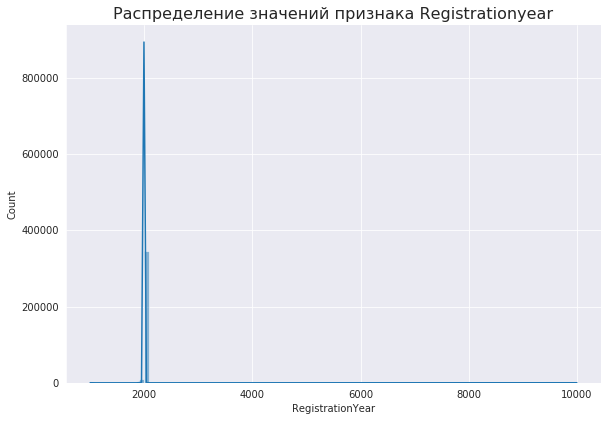

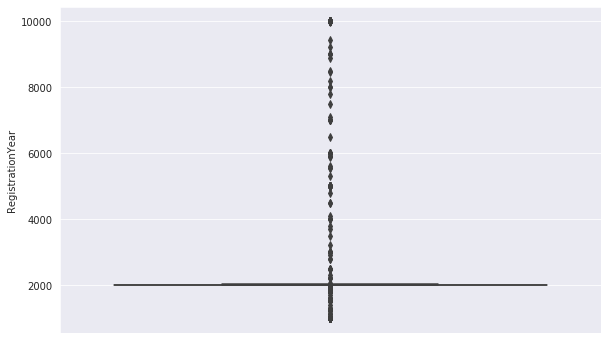

In [16]:
viz_distribution(data['RegistrationYear'], 'RegistrationYear')

С признаком RegistrationYear будем поступать следующим образом: так как нам неизвестно, о какой стране предоставлены данные и мы не можем узнать год, когда был зарегистрирован первый автомобиль в этой стране, будем считать, что год регистрации автомобиля не может быть меньше 1768 (если верить Википедии, то история первого автомобиля началась в 1768 году вместе с созданием паросиловых машин, способных перевозить человека) и больше 2020.

In [17]:
clean_data = clean_data.query('RegistrationYear > 1768')
len(clean_data)

354208

Выделим целевое значение и признаки
  
Разобьем данные на train и test, в соотношении 4 к 1
  
Train дополнительно разобьем на train_valid и valid, так же в соотношении 4 к 1

In [18]:
X = clean_data.drop(columns='Price')
y = clean_data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train_valid, X_valid, y_train_valid, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

print('Valid shapes:')
print(X_train_valid.shape, X_valid.shape, y_train_valid.shape, y_valid.shape)
print('Train/test shapes:')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Valid shapes:
(226692, 11) (56674, 11) (226692,) (56674,)
Train/test shapes:
(283366, 11) (70842, 11) (283366,) (70842,)


## Обучение моделей

Действовать будем по следующему плану:
  
- Напишем функцию которой на вход будут подаваться модель и датасеты и она будет возвращать время обучения, время предсказания и rmse
- Проверим 3 модели: Ridge, CatBoost, LightGBM.
- Для каждой моделии найдем лучшие гиперпараметры, и измерим время обучения на train
- Сведем данные по всем моделям в 1 таблицу

In [19]:
def model_eval(model, X_train, y_train, X_test, y_test):
    
    start = time.time()    
    model.fit(X_train, y_train)
    training_time = time.time() - start
    
    start = time.time()  
    y_pred = model.predict(X_test)
    predict_time = time.time() - start

    return training_time, predict_time, mse(y_test, y_pred)**0.5

**Ridge**
- Подготовим пайплайн: OHE -> scaler -> ridge
- На кросс валидации найдем лучшие параметры модели
- Измерим время обучения и запишем результаты на тесте.

In [20]:
res = []

In [21]:
pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', Ridge(random_state=SEED))
])

params = [
    {
        'model__alpha': np.logspace(-2, 2, 20)
    } 
]

In [22]:
cv = KFold(n_splits=3, shuffle=True, random_state=SEED)

grid = GridSearchCV(pipe,
                    param_grid=params,
                    cv=cv,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    verbose=False)

In [23]:
%%time
grid.fit(X_train_valid, y_train_valid);

CPU times: user 6min 39s, sys: 3.6 s, total: 6min 43s
Wall time: 6min 44s


GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('ohe',
                                        OneHotEncoder(categorical_features=None,
                                                      categories=None,
                                                      drop=None,
                                                      dtype=<class 'numpy.float64'>,
                                                      handle_unknown='ignore',
                                                      n_values=None,
                                                      sparse=True)),
                                       ('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=False,
                                                       with_std=Tru...
       6.95192796e

In [24]:
grid.best_params_

{'model__alpha': 100.0}

In [25]:
res.append(model_eval(grid.best_estimator_, X_train_valid, y_train_valid, X_valid, y_valid))

**LightGBM**
- Готовим категориальные признаки через Label Encoder
- Ищем лучшие параметры по сетке используя Scikit-learn API
- Обучаем модель на всей train выборке и замеряем время и RMSE

In [26]:
encoder = LabelEncoder()

lgb_train = X_train_valid.copy()
lgb_test = X_valid.copy()
lgb_full_train = X_train.copy()
lgb_full_test = X_test.copy()


cat_col_num = []

for col in cat_col:
    lgb_train[col] = encoder.fit_transform(lgb_train[col])
    lgb_test[col] = encoder.transform(lgb_test[col])
    lgb_full_train[col] = encoder.fit_transform(lgb_full_train[col])
    lgb_full_test[col] = encoder.transform(lgb_full_test[col])
    cat_col_num.append(data.columns.to_list().index(col))

gbm = lgb.LGBMRegressor(boosting_type='gbdt', verbose=0, seed=SEED)


params = {
    'learning_rate': np.logspace(-3, 0, 5),
    'n_estimators': [40, 60],
    'num_leaves': [21, 31, 41],
}

grid_gbm = GridSearchCV(gbm,
                        params,
                        cv=cv,
                        scoring='neg_mean_squared_error',
                        verbose=True)

In [27]:
%%time
grid_gbm.fit(lgb_train, y_train_valid);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 312.5min finished


CPU times: user 5h 14min 51s, sys: 2min 7s, total: 5h 16min 59s
Wall time: 5h 18min 47s


GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=No...
                                     reg_alpha=0.0, reg_lambda=0.0, seed=21,
                                     silent=True, subsample=1.0,
                                     subsample_for_bin=200000, subsample_freq=0,
                                     verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': array([0.001     , 0.00562341,

In [28]:
grid_gbm.best_params_

{'learning_rate': 0.1778279410038923, 'n_estimators': 60, 'num_leaves': 41}

In [29]:
res.append(model_eval(grid_gbm.best_estimator_, lgb_train, y_train_valid, lgb_test, y_valid))

**CatBoost**
- Все тоже самое что и для прошлых моделей

In [30]:
cbr = CatBoostRegressor(random_seed=SEED,
                        loss_function='RMSE',
                        silent=True,
                        cat_features=cat_col)

params = {
    'learning_rate': np.logspace(-3, 0, 5),
    'iterations': [40, 60],
    'depth': [6, 8, 10],
}

grid_cbr = GridSearchCV(cbr,
                        params,
                        cv=cv,
                        scoring='neg_mean_squared_error',
                        verbose=False)

In [31]:
%%time
grid_cbr.fit(X_train_valid, y_train_valid);

CPU times: user 26min 46s, sys: 4min, total: 30min 46s
Wall time: 33min 14s


GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7f61fffb5190>,
             iid='warn', n_jobs=None,
             param_grid={'depth': [6, 8, 10], 'iterations': [40, 60],
                         'learning_rate': array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=False)

In [32]:
grid_cbr.best_params_

{'depth': 10, 'iterations': 60, 'learning_rate': 0.1778279410038923}

In [33]:
res.append(model_eval(grid_cbr.best_estimator_, X_train_valid, y_train_valid, X_valid, y_valid))

## Анализ моделей

Сведем все данные в один датафрейм и посмотрим результаты на валидационной выборке
  
Для выбранной модели посмотрим результат на тесте

In [34]:
pd.DataFrame(data=res,
             index=['Ridge', 'LightGBM', 'CatBoost'],
             columns=['trainig_time', 'predic_time', 'score'])

,trainig_time,predic_time,score
Ridge,10.457880,0.182212,2145.323482
LightGBM,360.294771,0.501560,1805.812249
CatBoost,41.380523,0.251308,1804.239898


В данном случае наиболее подходящей моделью, с оптимальным качеством и быстродействием оказался: LightGBM
  
Проверим метрику на тесте

In [35]:
model = LGBMRegressor(boosting_type='gbdt', verbose=0, seed=SEED, learning_rate=0.1778279410038923, n_estimators=60, num_leaves=41)
model.fit(lgb_full_train, y_train)
mse(y_test, model.predict(lgb_full_test))**0.5

1810.4806796777282

**Вывод**
    
По требованиям задания больше всего подходит Лайт. Быстрее всех обучается, по качеству отдает соизмеримые значения с Котом. 2 из 3. Кот хорош и по скорости предсказаний и по качеству, ну уж очень долгий(возможно связано со спицификой данных).

Не стал перезапускать тетрадь, для обновления ячеек с кодом, уж очень долго будут выполнятся.

После очистки данных от выбросов и заполнения пропусков подбор параметров у Лайта стал намного дольше, Кот вырвался на первое место, если судить по целям проекта. Забавно, что ошибка увеличилась по сравнению с необработанными данными.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей